## Perceptron Activation Network
### With a learning example and comparison
_Overview:_ This is an implementation of the Perceptron Activation Network

In this notebook I present a model based on the biological brain, that combines Dropout, ReLU and Perceptron learning into a single learning algorithm - dubbed the Perceptron Activation Layer.  It is used like a typical Linear layer, however internally it implements a teacher-student signal for interrupting the flow of weights that do not contribute to the learning task.  A teacher network is responsible for computing a "teaching signal" that informs the "student network" which weights to activate and which to turn off.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import os
import glob
import pickle
import time
import string
from tqdm import tqdm
from PIL import Image
import numpy as np
import json

import torch as torch
import torch.nn as nn    
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models

In [2]:
print("Using PyTorch version: " + str(torch.__version__))

Using PyTorch version: 1.0.0


In [3]:
use_gpu = torch.cuda.is_available()
torch.manual_seed(7)

print("Using GPU: {}".format(use_gpu))

Using GPU: True


**Setup the dataset**

In [4]:
batch_size = 64

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/train/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/valid/', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

** Utility functions **

In [24]:
# Accuracy and loss meter
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Visualise a layer activation
def viz_layer(layer):
    fig = plt.figure(figsize=(16, 12))
    n_filters = layer.size()[1]
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))
    
    plt.show()

### Build the networks

**Build the LeNet5 network**

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax()
        
        
    def forward(self, x):
        # store last sample for visualisation
        self.lastx = x
        self.xc1 = self.conv1(x)
        self.xa1 = F.relu(self.xc1)
        x = F.max_pool2d(self.xa1, (2, 2))
        
        self.xc2 = self.conv2(x)
        self.xa2 = F.relu(self.xc2)
        x = F.max_pool2d(self.xa2, (2, 2))
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x 
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

**Define the Perceptron module**

In [8]:
class Perceptron(nn.Module):
    def __init__(self, inputs, outputs, minimum = 0.0):
        super(Perceptron, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
        # student network
        self.Sb = Parameter(torch.randn(self.outputs, requires_grad=True))
        self.SW = Parameter(torch.randn(self.outputs, self.inputs, requires_grad=True))
        
        # teacher network
        self.S_o, self.S_i = self.SW.size()
        self.Tb = Parameter(torch.randn(self.S_o * self.S_i, requires_grad=True))
        self.TW = Parameter(torch.randn(self.S_o * self.S_i, self.inputs, requires_grad=True))
        
        self.min_val = torch.tensor(minimum).float().cuda()
    
    def forward(self, x):
        # teacher signal
        self.Tz = F.linear(x, self.TW, self.Tb)
        self.Th = torch.matmul(self.Tz.t(), torch.ones(x.size()[0]).cuda())
        # perceptron gate
        self.o = torch.gt(self.Th, self.min_val).float()
        
        self.o = self.o.view(self.S_o, self.S_i)
        self.W = torch.mul(self.o, self.SW)
        
        # student signal
        x = F.linear(x, self.W, self.Sb)
        
        return x

**Build the Perceptron Activation Network**

In [9]:
class Tron(nn.Module):
    def __init__(self):
        super(Tron, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.tron1 = Perceptron(16*5*5, 120)
        self.tron2 = Perceptron(120, 84)
        
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        self.xc1 = self.conv1(x)
        self.xa1 = F.relu(self.xc1)
        x = F.max_pool2d(self.xa1, (2, 2))
        
        self.xc2 = self.conv2(x)
        self.xa2 = F.relu(self.xc2)
        x = F.max_pool2d(self.xa2, (2, 2))
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = self.tron1(x)
        x = self.tron2(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Training the network

**Loss plotting functions**

In [10]:
def plot_training(train_losses, valid_losses, title):
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training ' + title)
    plt.plot(valid_losses, label='Validation ' + title)
    plt.xlabel('epochs')
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

**Train the network**

In [11]:
def train(model, epoch, criterion, optimizer):
    
    model.train()
    train_loss = 0
    correct = 0
    num_train = len(train_loader.dataset)
    
    batch_time = AverageMeter()
    losses = AverageMeter()
    accs = AverageMeter()

    tic = time.time()
    with tqdm(total=num_train) as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            if use_gpu:
                data, target = data.cuda(), target.cuda()

            data, target = Variable(data), Variable(target)

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)
            loss.backward()

            train_loss += loss.item()

            predicted = torch.max(output, 1)[1]
            true_count = (predicted == target).float().sum()

            optimizer.step()
            
            correct += true_count
            acc = 100 * (true_count / len(target))

            # store
            losses.update(loss.item(), data.size()[0])
            accs.update(acc.item(), data.size()[0])
            
            # measure elapsed time
            toc = time.time()
            batch_time.update(toc-tic)

            pbar.set_description(
                (
                    "{:.1f}s - loss: {:.3f} - acc: {:.3f}".format(
                        (toc-tic), loss.item(), acc.item()
                    )
                )
            )
            pbar.update(batch_size)
        
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
        
    return train_loss, correct / len(train_loader.dataset)

In [12]:
def test(model, criterion, optimizer):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        loss = criterion(output, target)
        
        test_loss += loss.item()
        predicted = torch.max(output, 1)[1]
        correct += (predicted == target).float().sum()
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

In [13]:
# Train Model
def train_model(model, epochs):
    if (use_gpu):
        model.cuda()
    
    criteria = nn.NLLLoss()
    optimise = optim.SGD(model.parameters(), lr=0.003)
    scheduler = optim.lr_scheduler.StepLR(optimise, step_size=10, gamma=0.5)
    
    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []

    for e in range(epochs):
        print("Epoch: {} ...".format(e))
        scheduler.step()
        
        t_loss, t_acc = train(model, e, criteria, optimise)
        v_loss, v_acc = test(model, criteria, optimise)

        train_losses.append(t_loss)
        valid_losses.append(v_loss)
        train_accs.append(t_acc)
        valid_accs.append(v_acc)
    
    plot_training(train_losses, valid_losses, 'Loss')
    plot_training(train_accs, valid_accs, 'Accuracy')

In [14]:
# Training Parameters
epochs = 50

**Train LeNet5**

In [15]:
# Standard LeNet5
lenet5 = LeNet5()

Epoch: 0 ...


  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
16.9s - loss: 2.286 - acc: 18.750: : 60032it [00:16, 3549.31it/s]                                                      



Train set: Average loss: 2154.0102, Accuracy: 6664.0/60000 (11.11%)
Test set: Average loss: 358.8486, Accuracy: 2073.0/10000 (20.73%)

Epoch: 1 ...


16.1s - loss: 2.149 - acc: 50.000: : 60032it [00:16, 3739.26it/s]                                                      



Train set: Average loss: 2103.9590, Accuracy: 26521.0/60000 (44.20%)
Test set: Average loss: 334.1136, Accuracy: 5597.0/10000 (55.97%)

Epoch: 2 ...


16.1s - loss: 0.442 - acc: 93.750: : 60032it [00:16, 3729.43it/s]                                                      



Train set: Average loss: 1272.3268, Accuracy: 39111.0/60000 (65.18%)
Test set: Average loss: 106.3548, Accuracy: 7909.0/10000 (79.09%)

Epoch: 3 ...


16.1s - loss: 0.217 - acc: 93.750: : 60032it [00:16, 3728.39it/s]                                                      



Train set: Average loss: 438.4991, Accuracy: 51639.0/60000 (86.07%)
Test set: Average loss: 54.2942, Accuracy: 8917.0/10000 (89.17%)

Epoch: 4 ...


15.9s - loss: 0.173 - acc: 96.875: : 60032it [00:15, 3765.80it/s]                                                      



Train set: Average loss: 282.7756, Accuracy: 54558.0/60000 (90.93%)
Test set: Average loss: 39.2860, Accuracy: 9191.0/10000 (91.91%)

Epoch: 5 ...


15.9s - loss: 0.128 - acc: 96.875: : 60032it [00:15, 3783.83it/s]                                                      



Train set: Average loss: 220.0950, Accuracy: 55741.0/60000 (92.90%)
Test set: Average loss: 31.8308, Accuracy: 9353.0/10000 (93.53%)

Epoch: 6 ...


15.9s - loss: 0.095 - acc: 96.875: : 60032it [00:15, 3768.58it/s]                                                      



Train set: Average loss: 183.3780, Accuracy: 56417.0/60000 (94.03%)
Test set: Average loss: 27.0437, Accuracy: 9444.0/10000 (94.44%)

Epoch: 7 ...


15.9s - loss: 0.076 - acc: 100.000: : 60032it [00:15, 3777.49it/s]                                                     



Train set: Average loss: 159.1614, Accuracy: 56916.0/60000 (94.86%)
Test set: Average loss: 23.7500, Accuracy: 9505.0/10000 (95.05%)

Epoch: 8 ...


16.0s - loss: 0.063 - acc: 100.000: : 60032it [00:16, 3749.70it/s]                                                     



Train set: Average loss: 142.0263, Accuracy: 57241.0/60000 (95.40%)
Test set: Average loss: 21.3520, Accuracy: 9550.0/10000 (95.50%)

Epoch: 9 ...


15.9s - loss: 0.054 - acc: 100.000: : 60032it [00:15, 3772.35it/s]                                                     



Train set: Average loss: 129.2510, Accuracy: 57480.0/60000 (95.80%)
Test set: Average loss: 19.6170, Accuracy: 9592.0/10000 (95.92%)

Epoch: 10 ...


15.9s - loss: 0.046 - acc: 100.000: : 60032it [00:15, 3822.78it/s]                                                     



Train set: Average loss: 118.5490, Accuracy: 57688.0/60000 (96.15%)
Test set: Average loss: 17.7929, Accuracy: 9635.0/10000 (96.35%)

Epoch: 11 ...


15.9s - loss: 0.043 - acc: 100.000: : 60032it [00:15, 3769.70it/s]                                                     



Train set: Average loss: 113.8642, Accuracy: 57774.0/60000 (96.29%)
Test set: Average loss: 17.1635, Accuracy: 9641.0/10000 (96.41%)

Epoch: 12 ...


16.0s - loss: 0.039 - acc: 100.000: : 60032it [00:16, 3741.58it/s]                                                     



Train set: Average loss: 109.7723, Accuracy: 57843.0/60000 (96.40%)
Test set: Average loss: 16.5872, Accuracy: 9655.0/10000 (96.55%)

Epoch: 13 ...


16.0s - loss: 0.037 - acc: 100.000: : 60032it [00:16, 3746.87it/s]                                                     



Train set: Average loss: 106.0688, Accuracy: 57941.0/60000 (96.57%)
Test set: Average loss: 16.0619, Accuracy: 9665.0/10000 (96.65%)

Epoch: 14 ...


16.1s - loss: 0.035 - acc: 100.000: : 60032it [00:16, 3769.10it/s]                                                     



Train set: Average loss: 102.7066, Accuracy: 58012.0/60000 (96.69%)
Test set: Average loss: 15.5918, Accuracy: 9671.0/10000 (96.71%)

Epoch: 15 ...


16.0s - loss: 0.032 - acc: 100.000: : 60032it [00:16, 3750.01it/s]                                                     



Train set: Average loss: 99.6131, Accuracy: 58070.0/60000 (96.78%)
Test set: Average loss: 15.1581, Accuracy: 9677.0/10000 (96.77%)

Epoch: 16 ...


16.0s - loss: 0.030 - acc: 100.000: : 60032it [00:15, 3755.85it/s]                                                     



Train set: Average loss: 96.7337, Accuracy: 58123.0/60000 (96.87%)
Test set: Average loss: 14.7444, Accuracy: 9681.0/10000 (96.81%)

Epoch: 17 ...


16.2s - loss: 0.029 - acc: 100.000: : 60032it [00:16, 3593.11it/s]                                                     



Train set: Average loss: 94.0247, Accuracy: 58173.0/60000 (96.96%)
Test set: Average loss: 14.3583, Accuracy: 9691.0/10000 (96.91%)

Epoch: 18 ...


16.1s - loss: 0.027 - acc: 100.000: : 60032it [00:16, 3731.17it/s]                                                     



Train set: Average loss: 91.4753, Accuracy: 58225.0/60000 (97.04%)
Test set: Average loss: 14.0003, Accuracy: 9700.0/10000 (97.00%)

Epoch: 19 ...


16.1s - loss: 0.026 - acc: 100.000: : 60032it [00:16, 3739.71it/s]                                                     



Train set: Average loss: 89.0938, Accuracy: 58282.0/60000 (97.14%)
Test set: Average loss: 13.6572, Accuracy: 9703.0/10000 (97.03%)

Epoch: 20 ...


16.0s - loss: 0.024 - acc: 100.000: : 60032it [00:15, 3755.06it/s]                                                     



Train set: Average loss: 86.1409, Accuracy: 58334.0/60000 (97.22%)
Test set: Average loss: 12.9848, Accuracy: 9726.0/10000 (97.26%)

Epoch: 21 ...


16.1s - loss: 0.024 - acc: 100.000: : 60032it [00:16, 3739.50it/s]                                                     



Train set: Average loss: 84.8957, Accuracy: 58367.0/60000 (97.28%)
Test set: Average loss: 12.8236, Accuracy: 9729.0/10000 (97.29%)

Epoch: 22 ...


16.0s - loss: 0.023 - acc: 100.000: : 60032it [00:16, 3751.01it/s]                                                     



Train set: Average loss: 83.8175, Accuracy: 58387.0/60000 (97.31%)
Test set: Average loss: 12.6703, Accuracy: 9732.0/10000 (97.32%)

Epoch: 23 ...


16.0s - loss: 0.023 - acc: 100.000: : 60032it [00:15, 3747.79it/s]                                                     



Train set: Average loss: 82.7781, Accuracy: 58402.0/60000 (97.34%)
Test set: Average loss: 12.5231, Accuracy: 9740.0/10000 (97.40%)

Epoch: 24 ...


16.1s - loss: 0.022 - acc: 100.000: : 60032it [00:16, 3737.41it/s]                                                     



Train set: Average loss: 81.7733, Accuracy: 58416.0/60000 (97.36%)
Test set: Average loss: 12.3801, Accuracy: 9742.0/10000 (97.42%)

Epoch: 25 ...


16.0s - loss: 0.022 - acc: 100.000: : 60032it [00:16, 3746.51it/s]                                                     



Train set: Average loss: 80.7955, Accuracy: 58430.0/60000 (97.38%)
Test set: Average loss: 12.2400, Accuracy: 9745.0/10000 (97.45%)

Epoch: 26 ...


16.0s - loss: 0.021 - acc: 100.000: : 60032it [00:16, 3840.68it/s]                                                     



Train set: Average loss: 79.8389, Accuracy: 58452.0/60000 (97.42%)
Test set: Average loss: 12.1031, Accuracy: 9747.0/10000 (97.47%)

Epoch: 27 ...


16.0s - loss: 0.021 - acc: 100.000: : 60032it [00:16, 3747.64it/s]                                                     



Train set: Average loss: 78.9056, Accuracy: 58473.0/60000 (97.46%)
Test set: Average loss: 11.9756, Accuracy: 9752.0/10000 (97.52%)

Epoch: 28 ...


16.0s - loss: 0.020 - acc: 100.000: : 60032it [00:16, 3732.61it/s]                                                     



Train set: Average loss: 77.9973, Accuracy: 58492.0/60000 (97.49%)
Test set: Average loss: 11.8499, Accuracy: 9757.0/10000 (97.57%)

Epoch: 29 ...


16.0s - loss: 0.020 - acc: 100.000: : 60032it [00:15, 3754.38it/s]                                                     



Train set: Average loss: 77.1162, Accuracy: 58505.0/60000 (97.51%)
Test set: Average loss: 11.7305, Accuracy: 9760.0/10000 (97.60%)

Epoch: 30 ...


16.2s - loss: 0.019 - acc: 100.000: : 60032it [00:16, 3716.44it/s]                                                     



Train set: Average loss: 75.8766, Accuracy: 58541.0/60000 (97.57%)
Test set: Average loss: 11.4296, Accuracy: 9761.0/10000 (97.61%)

Epoch: 31 ...


16.1s - loss: 0.019 - acc: 100.000: : 60032it [00:16, 3733.71it/s]                                                     



Train set: Average loss: 75.3827, Accuracy: 58542.0/60000 (97.57%)
Test set: Average loss: 11.3702, Accuracy: 9764.0/10000 (97.64%)

Epoch: 32 ...


16.1s - loss: 0.019 - acc: 100.000: : 60032it [00:16, 3735.79it/s]                                                     



Train set: Average loss: 74.9529, Accuracy: 58550.0/60000 (97.58%)
Test set: Average loss: 11.3111, Accuracy: 9767.0/10000 (97.67%)

Epoch: 33 ...


16.1s - loss: 0.018 - acc: 100.000: : 60032it [00:16, 3730.74it/s]                                                     



Train set: Average loss: 74.5318, Accuracy: 58553.0/60000 (97.59%)
Test set: Average loss: 11.2526, Accuracy: 9769.0/10000 (97.69%)

Epoch: 34 ...


16.1s - loss: 0.018 - acc: 100.000: : 60032it [00:16, 3726.36it/s]                                                     



Train set: Average loss: 74.1189, Accuracy: 58562.0/60000 (97.60%)
Test set: Average loss: 11.1943, Accuracy: 9769.0/10000 (97.69%)

Epoch: 35 ...


16.1s - loss: 0.018 - acc: 100.000: : 60032it [00:16, 3723.33it/s]                                                     



Train set: Average loss: 73.7106, Accuracy: 58568.0/60000 (97.61%)
Test set: Average loss: 11.1368, Accuracy: 9770.0/10000 (97.70%)

Epoch: 36 ...


16.1s - loss: 0.018 - acc: 100.000: : 60032it [00:16, 3724.15it/s]                                                     



Train set: Average loss: 73.3076, Accuracy: 58576.0/60000 (97.63%)
Test set: Average loss: 11.0800, Accuracy: 9772.0/10000 (97.72%)

Epoch: 37 ...


16.1s - loss: 0.018 - acc: 100.000: : 60032it [00:16, 3718.91it/s]                                                     



Train set: Average loss: 72.9103, Accuracy: 58579.0/60000 (97.63%)
Test set: Average loss: 11.0245, Accuracy: 9772.0/10000 (97.72%)

Epoch: 38 ...


16.2s - loss: 0.017 - acc: 100.000: : 60032it [00:16, 3714.15it/s]                                                     



Train set: Average loss: 72.5177, Accuracy: 58587.0/60000 (97.65%)
Test set: Average loss: 10.9705, Accuracy: 9773.0/10000 (97.73%)

Epoch: 39 ...


16.0s - loss: 0.017 - acc: 100.000: : 60032it [00:15, 3760.10it/s]                                                     



Train set: Average loss: 72.1293, Accuracy: 58595.0/60000 (97.66%)
Test set: Average loss: 10.9161, Accuracy: 9773.0/10000 (97.73%)

Epoch: 40 ...


16.0s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3747.99it/s]                                                     



Train set: Average loss: 71.5988, Accuracy: 58622.0/60000 (97.70%)
Test set: Average loss: 10.8162, Accuracy: 9779.0/10000 (97.79%)

Epoch: 41 ...


16.1s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3733.22it/s]                                                     



Train set: Average loss: 71.3714, Accuracy: 58624.0/60000 (97.71%)
Test set: Average loss: 10.7882, Accuracy: 9779.0/10000 (97.79%)

Epoch: 42 ...


16.1s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3717.85it/s]                                                     



Train set: Average loss: 71.1782, Accuracy: 58626.0/60000 (97.71%)
Test set: Average loss: 10.7614, Accuracy: 9779.0/10000 (97.79%)

Epoch: 43 ...


16.1s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3736.24it/s]                                                     



Train set: Average loss: 70.9860, Accuracy: 58627.0/60000 (97.71%)
Test set: Average loss: 10.7345, Accuracy: 9780.0/10000 (97.80%)

Epoch: 44 ...


16.2s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3701.70it/s]                                                     



Train set: Average loss: 70.7968, Accuracy: 58629.0/60000 (97.72%)
Test set: Average loss: 10.7087, Accuracy: 9782.0/10000 (97.82%)

Epoch: 45 ...


16.1s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3744.62it/s]                                                     



Train set: Average loss: 70.6097, Accuracy: 58631.0/60000 (97.72%)
Test set: Average loss: 10.6821, Accuracy: 9781.0/10000 (97.81%)

Epoch: 46 ...


16.0s - loss: 0.016 - acc: 100.000: : 60032it [00:15, 3755.75it/s]                                                     



Train set: Average loss: 70.4232, Accuracy: 58635.0/60000 (97.72%)
Test set: Average loss: 10.6563, Accuracy: 9783.0/10000 (97.83%)

Epoch: 47 ...


16.0s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3746.10it/s]                                                     



Train set: Average loss: 70.2383, Accuracy: 58639.0/60000 (97.73%)
Test set: Average loss: 10.6304, Accuracy: 9784.0/10000 (97.84%)

Epoch: 48 ...


16.0s - loss: 0.016 - acc: 100.000: : 60032it [00:15, 3754.34it/s]                                                     



Train set: Average loss: 70.0541, Accuracy: 58640.0/60000 (97.73%)
Test set: Average loss: 10.6047, Accuracy: 9785.0/10000 (97.85%)

Epoch: 49 ...


16.0s - loss: 0.016 - acc: 100.000: : 60032it [00:16, 3746.01it/s]                                                     



Train set: Average loss: 69.8705, Accuracy: 58645.0/60000 (97.74%)
Test set: Average loss: 10.5789, Accuracy: 9786.0/10000 (97.86%)



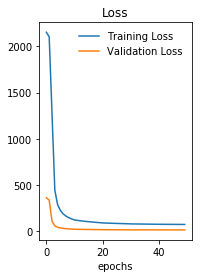

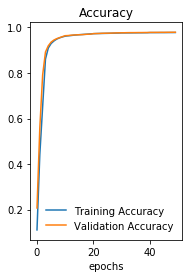

In [16]:
train_model(lenet5, epochs)

**Train MLP Activation Network**

In [17]:
# Model with MLP Activation
tron = Tron()

Epoch: 0 ...


  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
20.2s - loss: 0.155 - acc: 93.750: : 60032it [00:20, 2966.05it/s]                                                      



Train set: Average loss: 989.2777, Accuracy: 46346.0/60000 (77.24%)
Test set: Average loss: 64.3994, Accuracy: 8808.0/10000 (88.08%)

Epoch: 1 ...


19.8s - loss: 0.130 - acc: 93.750: : 60032it [00:19, 2994.86it/s]                                                      



Train set: Average loss: 255.7280, Accuracy: 55297.0/60000 (92.16%)
Test set: Average loss: 40.1812, Accuracy: 9267.0/10000 (92.67%)

Epoch: 2 ...


19.8s - loss: 0.024 - acc: 100.000: : 60032it [00:19, 3035.01it/s]                                                     



Train set: Average loss: 189.7612, Accuracy: 56400.0/60000 (94.00%)
Test set: Average loss: 33.7890, Accuracy: 9391.0/10000 (93.91%)

Epoch: 3 ...


19.8s - loss: 0.024 - acc: 100.000: : 60032it [00:19, 3034.96it/s]                                                     



Train set: Average loss: 161.9383, Accuracy: 56877.0/60000 (94.79%)
Test set: Average loss: 28.7581, Accuracy: 9466.0/10000 (94.66%)

Epoch: 4 ...


19.8s - loss: 0.089 - acc: 96.875: : 60032it [00:19, 3105.19it/s]                                                      



Train set: Average loss: 143.8265, Accuracy: 57201.0/60000 (95.33%)
Test set: Average loss: 22.3428, Accuracy: 9571.0/10000 (95.71%)

Epoch: 5 ...


19.8s - loss: 0.038 - acc: 100.000: : 60032it [00:19, 3046.24it/s]                                                     



Train set: Average loss: 130.1133, Accuracy: 57403.0/60000 (95.67%)
Test set: Average loss: 23.1003, Accuracy: 9553.0/10000 (95.53%)

Epoch: 6 ...


19.8s - loss: 0.011 - acc: 100.000: : 60032it [00:19, 3017.61it/s]                                                     



Train set: Average loss: 125.3422, Accuracy: 57501.0/60000 (95.83%)
Test set: Average loss: 19.4592, Accuracy: 9605.0/10000 (96.05%)

Epoch: 7 ...


19.8s - loss: 0.068 - acc: 96.875: : 60032it [00:19, 3034.93it/s]                                                      



Train set: Average loss: 118.2039, Accuracy: 57671.0/60000 (96.12%)
Test set: Average loss: 21.1549, Accuracy: 9588.0/10000 (95.88%)

Epoch: 8 ...


19.7s - loss: 0.050 - acc: 100.000: : 60032it [00:19, 3041.99it/s]                                                     



Train set: Average loss: 112.4400, Accuracy: 57775.0/60000 (96.29%)
Test set: Average loss: 19.4385, Accuracy: 9615.0/10000 (96.15%)

Epoch: 9 ...


19.8s - loss: 0.008 - acc: 100.000: : 60032it [00:19, 3030.88it/s]                                                     



Train set: Average loss: 111.3233, Accuracy: 57725.0/60000 (96.21%)
Test set: Average loss: 17.9567, Accuracy: 9644.0/10000 (96.44%)

Epoch: 10 ...


19.8s - loss: 0.042 - acc: 100.000: : 60032it [00:19, 3025.23it/s]                                                     



Train set: Average loss: 96.6987, Accuracy: 57996.0/60000 (96.66%)
Test set: Average loss: 17.1500, Accuracy: 9659.0/10000 (96.59%)

Epoch: 11 ...


19.9s - loss: 0.030 - acc: 100.000: : 60032it [00:19, 3023.48it/s]                                                     



Train set: Average loss: 95.8420, Accuracy: 58020.0/60000 (96.70%)
Test set: Average loss: 17.2222, Accuracy: 9648.0/10000 (96.48%)

Epoch: 12 ...


20.0s - loss: 0.033 - acc: 96.875: : 60032it [00:19, 3055.30it/s]                                                      



Train set: Average loss: 92.2820, Accuracy: 58112.0/60000 (96.85%)
Test set: Average loss: 16.5788, Accuracy: 9660.0/10000 (96.60%)

Epoch: 13 ...


19.8s - loss: 0.013 - acc: 100.000: : 60032it [00:19, 3026.38it/s]                                                     



Train set: Average loss: 90.1717, Accuracy: 58179.0/60000 (96.97%)
Test set: Average loss: 16.1267, Accuracy: 9679.0/10000 (96.79%)

Epoch: 14 ...


20.0s - loss: 0.015 - acc: 100.000: : 60032it [00:19, 3004.52it/s]                                                     



Train set: Average loss: 89.3217, Accuracy: 58149.0/60000 (96.92%)
Test set: Average loss: 16.5235, Accuracy: 9681.0/10000 (96.81%)

Epoch: 15 ...


19.9s - loss: 0.038 - acc: 100.000: : 60032it [00:19, 3001.77it/s]                                                     



Train set: Average loss: 89.4782, Accuracy: 58177.0/60000 (96.96%)
Test set: Average loss: 16.4862, Accuracy: 9683.0/10000 (96.83%)

Epoch: 16 ...


19.8s - loss: 0.074 - acc: 96.875: : 60032it [00:19, 3034.76it/s]                                                      



Train set: Average loss: 88.8232, Accuracy: 58169.0/60000 (96.95%)
Test set: Average loss: 16.4681, Accuracy: 9672.0/10000 (96.72%)

Epoch: 17 ...


20.0s - loss: 0.017 - acc: 100.000: : 60032it [00:20, 2995.46it/s]                                                     



Train set: Average loss: 86.3062, Accuracy: 58219.0/60000 (97.03%)
Test set: Average loss: 16.2816, Accuracy: 9666.0/10000 (96.66%)

Epoch: 18 ...


19.9s - loss: 0.036 - acc: 100.000: : 60032it [00:19, 3008.75it/s]                                                     



Train set: Average loss: 86.0126, Accuracy: 58211.0/60000 (97.02%)
Test set: Average loss: 16.8068, Accuracy: 9671.0/10000 (96.71%)

Epoch: 19 ...


20.0s - loss: 0.013 - acc: 100.000: : 60032it [00:19, 3006.86it/s]                                                     



Train set: Average loss: 86.2987, Accuracy: 58247.0/60000 (97.08%)
Test set: Average loss: 14.9515, Accuracy: 9697.0/10000 (96.97%)

Epoch: 20 ...


20.0s - loss: 0.015 - acc: 100.000: : 60032it [00:20, 2999.30it/s]                                                     



Train set: Average loss: 81.2291, Accuracy: 58327.0/60000 (97.21%)
Test set: Average loss: 15.3023, Accuracy: 9694.0/10000 (96.94%)

Epoch: 21 ...


19.9s - loss: 0.078 - acc: 96.875: : 60032it [00:19, 3019.62it/s]                                                      



Train set: Average loss: 80.0183, Accuracy: 58370.0/60000 (97.28%)
Test set: Average loss: 15.5546, Accuracy: 9701.0/10000 (97.01%)

Epoch: 22 ...


20.0s - loss: 0.038 - acc: 100.000: : 60032it [00:19, 3005.62it/s]                                                     



Train set: Average loss: 79.4934, Accuracy: 58373.0/60000 (97.29%)
Test set: Average loss: 15.6601, Accuracy: 9690.0/10000 (96.90%)

Epoch: 23 ...


19.9s - loss: 0.054 - acc: 100.000: : 60032it [00:19, 3013.72it/s]                                                     



Train set: Average loss: 78.5784, Accuracy: 58389.0/60000 (97.32%)
Test set: Average loss: 15.5762, Accuracy: 9703.0/10000 (97.03%)

Epoch: 24 ...


19.8s - loss: 0.039 - acc: 100.000: : 60032it [00:19, 3028.20it/s]                                                     



Train set: Average loss: 78.3389, Accuracy: 58416.0/60000 (97.36%)
Test set: Average loss: 15.7582, Accuracy: 9703.0/10000 (97.03%)

Epoch: 25 ...


19.9s - loss: 0.027 - acc: 100.000: : 60032it [00:19, 3020.85it/s]                                                     



Train set: Average loss: 78.4589, Accuracy: 58394.0/60000 (97.32%)
Test set: Average loss: 15.7050, Accuracy: 9681.0/10000 (96.81%)

Epoch: 26 ...


20.0s - loss: 0.037 - acc: 100.000: : 60032it [00:20, 2986.40it/s]                                                     



Train set: Average loss: 79.6025, Accuracy: 58380.0/60000 (97.30%)
Test set: Average loss: 14.9184, Accuracy: 9683.0/10000 (96.83%)

Epoch: 27 ...


19.9s - loss: 0.038 - acc: 100.000: : 60032it [00:19, 3019.05it/s]                                                     



Train set: Average loss: 77.3701, Accuracy: 58404.0/60000 (97.34%)
Test set: Average loss: 15.4224, Accuracy: 9699.0/10000 (96.99%)

Epoch: 28 ...


19.9s - loss: 0.058 - acc: 96.875: : 60032it [00:19, 3017.14it/s]                                                      



Train set: Average loss: 76.4408, Accuracy: 58416.0/60000 (97.36%)
Test set: Average loss: 15.7033, Accuracy: 9686.0/10000 (96.86%)

Epoch: 29 ...


19.9s - loss: 0.022 - acc: 100.000: : 60032it [00:19, 3021.56it/s]                                                     



Train set: Average loss: 75.9263, Accuracy: 58426.0/60000 (97.38%)
Test set: Average loss: 16.2608, Accuracy: 9677.0/10000 (96.77%)

Epoch: 30 ...


19.9s - loss: 0.060 - acc: 100.000: : 60032it [00:19, 3014.98it/s]                                                     



Train set: Average loss: 74.7741, Accuracy: 58447.0/60000 (97.41%)
Test set: Average loss: 15.3384, Accuracy: 9686.0/10000 (96.86%)

Epoch: 31 ...


19.8s - loss: 0.026 - acc: 100.000: : 60032it [00:19, 3024.45it/s]                                                     



Train set: Average loss: 73.9123, Accuracy: 58460.0/60000 (97.43%)
Test set: Average loss: 15.5927, Accuracy: 9680.0/10000 (96.80%)

Epoch: 32 ...


19.9s - loss: 0.050 - acc: 100.000: : 60032it [00:19, 3014.48it/s]                                                     



Train set: Average loss: 73.7454, Accuracy: 58474.0/60000 (97.46%)
Test set: Average loss: 15.2779, Accuracy: 9685.0/10000 (96.85%)

Epoch: 33 ...


20.0s - loss: 0.107 - acc: 100.000: : 60032it [00:20, 2511.41it/s]                                                     



Train set: Average loss: 74.3455, Accuracy: 58444.0/60000 (97.41%)
Test set: Average loss: 16.1564, Accuracy: 9675.0/10000 (96.75%)

Epoch: 34 ...


19.9s - loss: 0.058 - acc: 96.875: : 60032it [00:19, 3023.70it/s]                                                      



Train set: Average loss: 74.1833, Accuracy: 58474.0/60000 (97.46%)
Test set: Average loss: 15.2979, Accuracy: 9696.0/10000 (96.96%)

Epoch: 35 ...


19.9s - loss: 0.049 - acc: 100.000: : 60032it [00:19, 3019.42it/s]                                                     



Train set: Average loss: 74.3266, Accuracy: 58454.0/60000 (97.42%)
Test set: Average loss: 15.7330, Accuracy: 9682.0/10000 (96.82%)

Epoch: 36 ...


19.8s - loss: 0.034 - acc: 100.000: : 60032it [00:19, 3030.58it/s]                                                     



Train set: Average loss: 73.9909, Accuracy: 58462.0/60000 (97.44%)
Test set: Average loss: 15.6793, Accuracy: 9687.0/10000 (96.87%)

Epoch: 37 ...


19.9s - loss: 0.048 - acc: 100.000: : 60032it [00:19, 3022.31it/s]                                                     



Train set: Average loss: 73.8159, Accuracy: 58489.0/60000 (97.48%)
Test set: Average loss: 16.0362, Accuracy: 9673.0/10000 (96.73%)

Epoch: 38 ...


19.9s - loss: 0.040 - acc: 100.000: : 60032it [00:19, 3016.53it/s]                                                     



Train set: Average loss: 73.3135, Accuracy: 58449.0/60000 (97.42%)
Test set: Average loss: 15.6698, Accuracy: 9679.0/10000 (96.79%)

Epoch: 39 ...


19.8s - loss: 0.164 - acc: 93.750: : 60032it [00:19, 3030.08it/s]                                                      



Train set: Average loss: 74.0166, Accuracy: 58453.0/60000 (97.42%)
Test set: Average loss: 16.2312, Accuracy: 9668.0/10000 (96.68%)

Epoch: 40 ...


19.9s - loss: 0.053 - acc: 96.875: : 60032it [00:19, 3018.57it/s]                                                      



Train set: Average loss: 72.6275, Accuracy: 58506.0/60000 (97.51%)
Test set: Average loss: 16.3040, Accuracy: 9663.0/10000 (96.63%)

Epoch: 41 ...


19.9s - loss: 0.043 - acc: 100.000: : 60032it [00:19, 3012.49it/s]                                                     



Train set: Average loss: 72.6314, Accuracy: 58484.0/60000 (97.47%)
Test set: Average loss: 15.9081, Accuracy: 9675.0/10000 (96.75%)

Epoch: 42 ...


19.9s - loss: 0.039 - acc: 100.000: : 60032it [00:19, 3016.74it/s]                                                     



Train set: Average loss: 71.3698, Accuracy: 58479.0/60000 (97.47%)
Test set: Average loss: 15.7054, Accuracy: 9661.0/10000 (96.61%)

Epoch: 43 ...


19.8s - loss: 0.145 - acc: 90.625: : 60032it [00:19, 3027.19it/s]                                                      



Train set: Average loss: 71.6463, Accuracy: 58472.0/60000 (97.45%)
Test set: Average loss: 16.0483, Accuracy: 9664.0/10000 (96.64%)

Epoch: 44 ...


19.9s - loss: 0.052 - acc: 100.000: : 60032it [00:19, 3017.00it/s]                                                     



Train set: Average loss: 71.1685, Accuracy: 58517.0/60000 (97.53%)
Test set: Average loss: 16.0111, Accuracy: 9668.0/10000 (96.68%)

Epoch: 45 ...


19.9s - loss: 0.061 - acc: 100.000: : 60032it [00:19, 3020.39it/s]                                                     



Train set: Average loss: 72.1576, Accuracy: 58483.0/60000 (97.47%)
Test set: Average loss: 15.8982, Accuracy: 9665.0/10000 (96.65%)

Epoch: 46 ...


19.9s - loss: 0.033 - acc: 100.000: : 60032it [00:19, 3015.44it/s]                                                     



Train set: Average loss: 72.1337, Accuracy: 58501.0/60000 (97.50%)
Test set: Average loss: 16.3417, Accuracy: 9675.0/10000 (96.75%)

Epoch: 47 ...


19.9s - loss: 0.051 - acc: 96.875: : 60032it [00:19, 3019.52it/s]                                                      



Train set: Average loss: 71.6919, Accuracy: 58509.0/60000 (97.51%)
Test set: Average loss: 16.0821, Accuracy: 9668.0/10000 (96.68%)

Epoch: 48 ...


19.9s - loss: 0.070 - acc: 96.875: : 60032it [00:19, 3017.14it/s]                                                      



Train set: Average loss: 71.3919, Accuracy: 58527.0/60000 (97.54%)
Test set: Average loss: 16.0052, Accuracy: 9682.0/10000 (96.82%)

Epoch: 49 ...


19.9s - loss: 0.040 - acc: 100.000: : 60032it [00:19, 3011.46it/s]                                                     



Train set: Average loss: 70.8023, Accuracy: 58538.0/60000 (97.56%)
Test set: Average loss: 15.8987, Accuracy: 9673.0/10000 (96.73%)



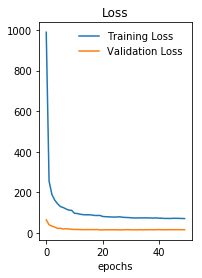

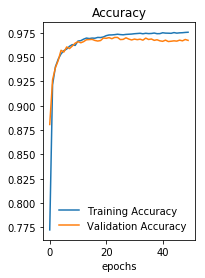

In [18]:
# Training Model 2
train_model(tron, epochs)

### Visualise the activations

**Visualise the input image**

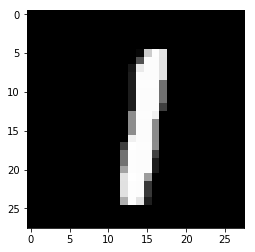

In [19]:
plt.imshow(np.squeeze(lenet5.lastx.cpu()[0,0].data.numpy()), cmap='gray')

**Visualise the LetNet layers**

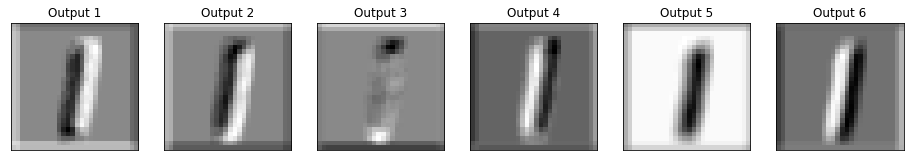

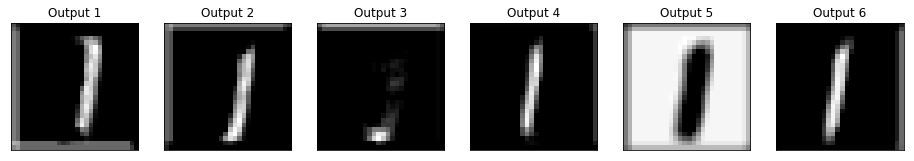

In [26]:
viz_layer(lenet5.xc1.cpu())
viz_layer(lenet5.xa1.cpu())

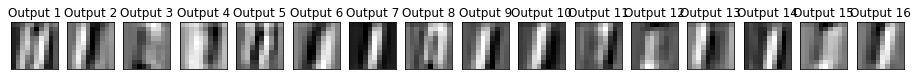

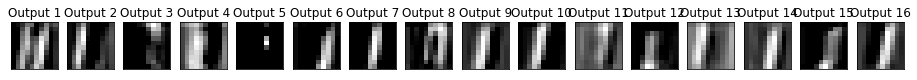

In [27]:
viz_layer(lenet5.xc2.cpu())
viz_layer(lenet5.xa2.cpu())

**Visualise the PAN layers**

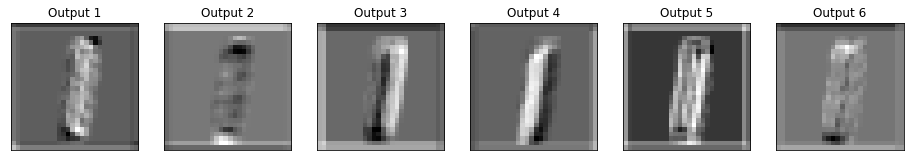

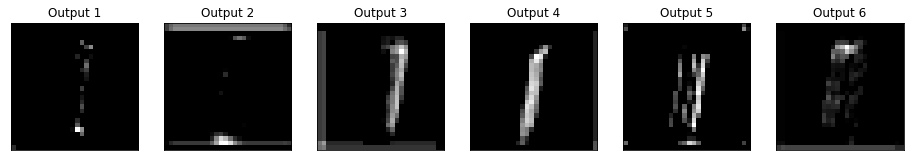

In [28]:
viz_layer(tron.xc1.cpu())
viz_layer(tron.xa1.cpu())

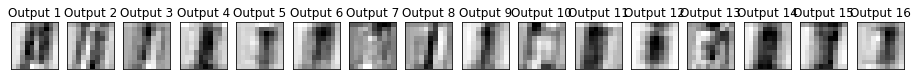

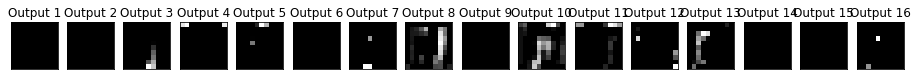

In [29]:
viz_layer(tron.xc2.cpu())
viz_layer(tron.xa2.cpu())